Ridho AKbar (1301180290)

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files # upload token API Kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ridhoakbarrr","key":"fc6f5ba27c7c6bb22cb903d6b7ba8c75"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.jso

chmod: cannot access '/root/.kaggle/kaggle.jso': No such file or directory


In [4]:
!kaggle datasets download 'andrewmvd/face-mask-detection'

 97% 385M/398M [00:03<00:00, 93.5MB/s]
100% 398M/398M [00:03<00:00, 105MB/s] 


In [5]:
import zipfile
local_zip = 'face-mask-detection.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('face-mask-detection')
zip_ref.close()
     

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import cv2
import seaborn as sns 


input_data_path = '/content/face-mask-detection/images'
annotations_path = "/content/face-mask-detection/annotations"
images = [*os.listdir("/content/face-mask-detection/images")]
output_data_path =  '.'

In [9]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [10]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [11]:
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

In [12]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss586,400,267,3,with_mask,111,106,146,164
1,maksssksksss586,400,267,3,with_mask,194,115,224,164
2,maksssksksss586,400,267,3,with_mask,22,120,50,161
3,maksssksksss627,400,225,3,without_mask,42,27,69,52
4,maksssksksss627,400,225,3,without_mask,132,5,144,20


In [13]:
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df["file"] == final_test_image]
images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

In [14]:
df

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss586,400,267,3,with_mask,111,106,146,164
1,maksssksksss586,400,267,3,with_mask,194,115,224,164
2,maksssksksss586,400,267,3,with_mask,22,120,50,161
3,maksssksksss627,400,225,3,without_mask,42,27,69,52
4,maksssksksss627,400,225,3,without_mask,132,5,144,20
...,...,...,...,...,...,...,...,...,...
4067,maksssksksss149,400,283,3,with_mask,180,103,215,136
4068,maksssksksss149,400,283,3,with_mask,287,53,315,85
4069,maksssksksss149,400,283,3,with_mask,315,57,341,89
4070,maksssksksss149,400,283,3,with_mask,330,104,359,133


In [15]:
df["name"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: name, dtype: int64

Text(0, 0.5, 'name')

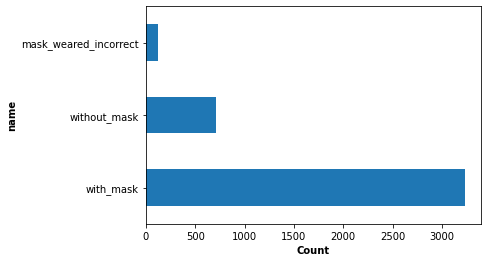

In [16]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('name', fontsize = 10, fontweight = 'bold')

In [17]:
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [18]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [19]:
def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [20]:
cropped_faces = [extract_faces(img, df) for img in images]

In [21]:
flat_cropped_faces = sum(cropped_faces, [])

In [22]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [23]:
print(len(with_mask))
print(len(without_mask))
print(len(mask_weared_incorrect))
print(len(with_mask) + len(without_mask) + len(mask_weared_incorrect))

3231
715
123
4069


In [24]:
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [25]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  

In [26]:
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
        
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

In [27]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [29]:
batch_size = 8
epochs = 50

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='/content/train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='/content/val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='/content/test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)


Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [30]:
data_size = len(train_generator)

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [31]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [33]:
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [34]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

Epoch 1/50


<ipython-input-34-b6bd8b88a620>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


50/50 [==============================] - 4s 45ms/step - loss: 0.5813 - accuracy: 0.7900 - recall: 0.7550 - precision: 0.8075 - auc: 0.9119 - val_loss: 0.5348 - val_accuracy: 0.7917 - val_recall: 0.7500 - val_precision: 0.8571 - val_auc: 0.9321 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 1s 29ms/step - loss: 0.3336 - accuracy: 0.8825 - recall: 0.8550 - precision: 0.9000 - auc: 0.9703 - val_loss: 0.3645 - val_accuracy: 0.8611 - val_recall: 0.8611 - val_precision: 0.8857 - val_auc: 0.9592 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 1s 28ms/step - loss: 0.3188 - accuracy: 0.8950 - recall: 0.8850 - precision: 0.9054 - auc: 0.9709 - val_loss: 0.2874 - val_accuracy: 0.9167 - val_recall: 0.9167 - val_precision: 0.9167 - val_auc: 0.9793 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 1s 29ms/step - loss: 0.2928 - accuracy: 0.9250 - recall: 0.9125 - precision: 0.9241 - auc: 0.9734 - val_loss: 0.1545 - val_accuracy: 0.9722 - val_recall: 0

In [35]:
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print(f'{model_loss} || {model_acc*100} || {recall*100} || {precision*100} || {auc*100}')

31/31 [==============================] - 0s 10ms/step - loss: 0.1680 - accuracy: 0.9383 - recall: 0.9383 - precision: 0.9540 - auc: 0.9926
0.1679672747850418 || 93.82715821266174 || 93.82715821266174 || 95.39749026298523 || 99.25612807273865


In [36]:
predictions = model.predict(test_generator)
predictions

31/31 [==============================] - 0s 10ms/step


array([[6.99873567e-02, 4.33686003e-02, 8.86644006e-01],
       [2.95130294e-02, 3.16367336e-02, 9.38850164e-01],
       [1.64462477e-01, 7.75550723e-01, 5.99867105e-02],
       [7.94293344e-01, 1.86065882e-01, 1.96407996e-02],
       [1.42262593e-01, 8.54745448e-01, 2.99175247e-03],
       [9.00264233e-02, 9.09568071e-01, 4.05566301e-04],
       [8.16222727e-02, 9.17205632e-01, 1.17199274e-03],
       [2.06018817e-02, 9.69828725e-01, 9.56935994e-03],
       [7.60887415e-05, 9.99923646e-01, 2.22604058e-07],
       [2.74931490e-02, 9.30113673e-01, 4.23931926e-02],
       [8.13402221e-05, 9.99918163e-01, 5.02778335e-07],
       [2.37461622e-03, 9.97494698e-01, 1.30533910e-04],
       [3.93582731e-02, 9.55300391e-01, 5.34128956e-03],
       [1.19892545e-02, 9.86844301e-01, 1.16641342e-03],
       [2.49212477e-02, 9.73724961e-01, 1.35379063e-03],
       [8.46637636e-02, 8.46440494e-01, 6.88957274e-02],
       [1.70567853e-03, 9.98219013e-01, 7.52692213e-05],
       [6.32480765e-03, 9.89069

In [37]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

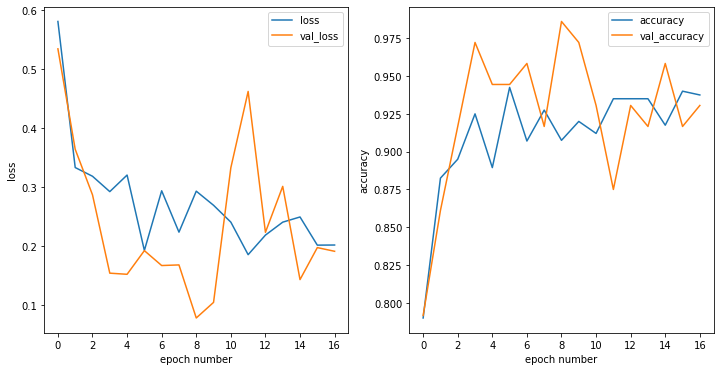

In [38]:
plot_loss_and_accuracy(model_history.history)

31/31 [==============================] - 0s 12ms/step
with_mask || with_mask


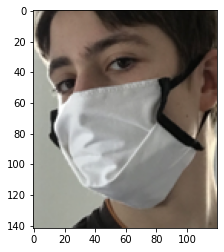

In [39]:
paths = test_generator.filenames
y_pred = model.predict(test_generator).argmax(axis=1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

In [40]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

31/31 [==============================] - 0s 11ms/step


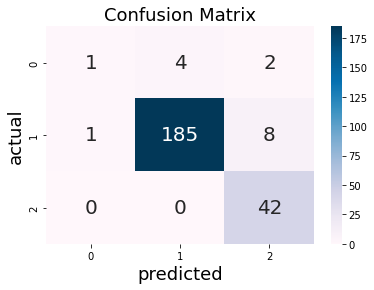

In [41]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

In [42]:
display(classes)
np.bincount(y_pred)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

array([  2, 189,  52])